In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, vstack, join
import hhana
sam = hhana.SuperCat('hsc-hugs')
hhana.add_regions_col(sam.cat)
sam_big = sam.copy()
sam_big.make_cuts(sam_big['FLUX_RADIUS(i)']>3.2/0.168)
sam_big.make_cuts(sam_big['candy']==1)


In [2]:
galex_hugs_ids = dict(
    AIS=[22, 25, 38, 55, 68, 76, 122, 238, 405, 409],
    MIS=[23, 110, 112, 115, 125, 127, 138, 139, 146, 
         158, 171, 173, 243, 286, 314, 320, 329, 331, 
         336, 351, 392],
    DIS=[19, 24, 48, 82],
    GII=[33, 115, 118, 119, 212, 215, 216, 230],
    NGS=[27, 33]
)

In [3]:
galex = ascii.read('../../hsc-hugs-paper-I/data/MAST_xmatch_GALEX_with_3-6-2017-sample.csv')
galex.sort('distanceArcMin')
flag_cut = galex['nuv_artifact'] != 2
flag_cut &= galex['nuv_artifact'] != 4
flag_cut &= galex['fuv_artifact'] != 4
galex = galex[flag_cut]
galex = galex[galex['nuv_mag']>0]
size_cut = sam[galex['hugs-id']]['FLUX_RADIUS(i)']>3.0/0.168
ra_cut = (sam[galex['hugs-id']]['ra'] < 4*15) | (sam[galex['hugs-id']]['ra'] > 10.5*15) 
galex = galex[size_cut & ra_cut]
    
AIS = galex[galex['survey']=='AIS']
DIS = galex[galex['survey']=='DIS']
GII = galex[galex['survey']=='GII']
MIS = galex[galex['survey']=='MIS']
NGS = galex[galex['survey']=='NGS']

for s in [AIS, DIS, GII, MIS, NGS]:
    print('{} has {} entries'.format(s['survey'][0], len(s)))

AIS has 35 entries
DIS has 24 entries
GII has 23 entries
MIS has 30 entries
NGS has 1 entries


In [25]:
def get_unique(table):
    table_unique = Table()
    for hid in np.unique(table['hugs-id']):
        id_cut = table['hugs-id']==hid
        idx_min= np.argmin(table[id_cut]['nuv_magerr'])
        table_unique = vstack([table_unique, table[id_cut][idx_min]])
    return table_unique
AIS = get_unique(AIS)
MIS = get_unique(MIS)
DIS = get_unique(DIS)
GII = get_unique(GII)
NGS = get_unique(NGS)
#galex = get_unique(galex)

for s in [AIS, DIS, GII, MIS, NGS]:
    print('{} has {} unique entries'.format(s['survey'][0], len(s)))

AIS has 30 unique entries
DIS has 10 unique entries
GII has 20 unique entries
MIS has 24 unique entries
NGS has 1 unique entries


In [5]:
print('hours restricted to', 10.5*15, 4*15, 'hours')

hours restricted to 157.5 60 hours


In [6]:
if False:
    region = 4
    sam_reg = sam.copy()
    sam_reg.cat = sam_reg[galex_hugs_ids['MIS']]
    sam_reg.cat = sam_reg[sam_reg['region']==region]
    sam_reg.cat = sam_reg[sam_reg['FLUX_RADIUS(i)']>3.0/0.168]
    fig, ax = hhana.plot.circles_on_region(sam_big[sam_big['region']==region], 
                                           fp=footprints[region].cat, sam_kws={'c':'r'})
    hhana.plot.circles_on_region(sam_reg, subplots=(fig, ax), sam_kws={'c':'b'});

In [7]:
#hhana.nbtools.display_obj_near_point(sam_reg, (36, -5), 30, print_info=True, size=300)

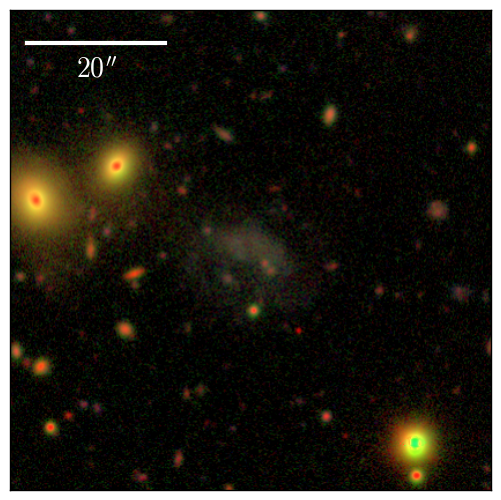

In [8]:
hhana.nbtools.display_candy(336)

In [9]:
proposed_hugs_ids = dict(
    MIS=[138, 139, 146, 243, 115, 173, 158],
    GII=[118, 212, 119, 230, 215],
    NGS=[27]
)

In [10]:
surveys = ['MIS', 'GII', 'NGS']
size = 200
for survey in surveys:
    for hid in proposed_hugs_ids[survey]:
        print('hsc-hugs #{}'.format(hid))
        hhana.nbtools.display_galex_compare(hid, size=size, survey=survey)

hsc-hugs #138


hsc-hugs #139


hsc-hugs #146


hsc-hugs #243


hsc-hugs #115


hsc-hugs #173


hsc-hugs #158


hsc-hugs #118


hsc-hugs #212


hsc-hugs #119


hsc-hugs #230


hsc-hugs #215


hsc-hugs #27


In [11]:
def difference_matrix(a):
    x = np.reshape(a, (len(a), 1))
    return x - x.transpose()

In [24]:
galex[galex['hugs-id']==118]

ra,dec,hugs-id,MatchID,MatchRA,MatchDEC,distanceArcMin,survey,fov_radius,IAUName,band,nuv_exptime,fuv_exptime,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,fuv_flux,fuv_fluxerr,nuv_flux,nuv_fluxerr,e_bv,ra_cent,dec_cent,xCenter,yCenter,SSAPFitsFile,nuv_flux_auto,nuv_flux_aper_7,nuv_artifact,fuv_flux_auto,fuv_flux_aper_7,fuv_artifact
float64,float64,int64,int64,float64,float64,float64,str3,float64,str22,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str97,float64,float64,int64,float64,float64,int64
181.231563552,-0.695596888302,118,6382596985277383509,181.231127984,-0.695609692959,0.0261434354699,AIS,0.459298,GALEX J120455.4-004144,3,267.05,267.05,20.77091,0.2432536,21.39005,0.3130894,17.84991,3.998209,10.09201,2.909484,0.0254171,181.53221,-0.34875,1916.618,1934.682,--,0.2992112,0.2939927,0,0.1658189,0.1489455,0
181.231563552,-0.695596888302,118,3196643278287022145,181.231100283,-0.696117813972,0.0418260571505,GII,0.5652049,GALEX J120455.4-004146,3,1681.15,1681.15,21.07628,0.1255696,20.35331,0.08964916,13.47378,1.557917,26.22266,2.164677,0.0254171,181.02577,-1.22272,1912.542,1893.147,--,0.7774583,0.6247374,1,0.1251663,0.1245499,0


118 1.03674
212 0.0
119 0.0
230 0.0
215 0.0


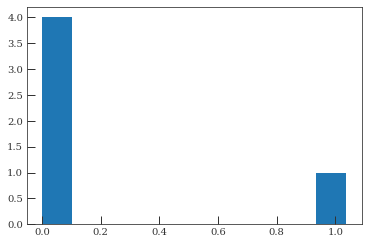

In [22]:
match = Table()
max_diffs = []
for hid in proposed_hugs_ids['GII']:
    match = vstack([match, galex[galex['hugs-id']==hid].copy()])
    nuv = galex[galex['hugs-id']==hid]['nuv_mag']
    max_diffs.append(difference_matrix(nuv).max())
    print(hid,difference_matrix(nuv).max())
plt.hist(max_diffs);

In [26]:
galex_unique = get_unique(galex.copy())
galex_unique = join(galex_unique, sam.cat, keys='hugs-id')
match = Table()
for row in proposed_hugs_ids.values():
    for hid in row:
        match = vstack([match, galex_unique[galex_unique['hugs-id']==hid].copy()])

In [ ]:
match

In [32]:
cols = ['hugs-id','MatchRA', 'MatchDEC', 'nuv_mag', 'nuv_magerr', 'm_tot(g)', 
        'mu_aper_0(g)', 'm_tot(i)', 'mu_aper_0(i)', 'survey']
match_pd = match[cols].to_pandas()

In [33]:
match_pd

,hugs-id,MatchRA,MatchDEC,nuv_mag,nuv_magerr,m_tot(g),mu_aper_0(g),m_tot(i),mu_aper_0(i),survey
0,27.0,39.481638,-6.256399,20.45533,0.068484,18.142255,24.123477,17.481761,23.653877,NGS
1,118.0,181.231100,-0.696118,20.35331,0.089649,18.524776,24.658477,17.981957,24.111877,GII
2,212.0,178.962284,0.081257,22.69895,0.150345,20.154546,24.154277,19.649147,23.811777,GII
3,119.0,180.356050,-0.312954,22.02215,0.189937,20.305673,24.318777,19.776639,23.581777,GII
4,230.0,182.029685,0.868233,21.46568,0.383365,19.709995,25.275977,19.389707,25.013077,AIS
5,215.0,181.192391,1.298610,21.01833,0.068610,19.622815,24.399877,19.203925,23.998877,GII
6,138.0,215.254981,-1.001776,21.79939,0.175279,21.112879,24.372977,20.807708,23.990777,MIS
7,139.0,215.021138,-0.436111,21.78429,0.123280,20.024971,24.498077,19.370849,24.020977,MIS
8,146.0,221.121000,-0.118818,21.47039,0.144983,19.898782,24.078977,19.484248,23.545677,MIS
9,243.0,215.283000,0.884880,21.81045,0.136079,22.331077,25.024277,20.164143,24.812777,MIS


In [34]:
match_pd.to_csv('/Users/protostar/Desktop/gemini-ft-sample.csv', index=False)